# Deep CORAL Implementation

## Introduction
Machine learning practitioners are frequently hindered and set back in their efforts by an inadequate amount of labeled data in their chosen domains. In these situations gathering additional relevant, labeled data is often prohibitively expensive or time consuming. As a result ML professionals frequently seek methods of incorporating additional readily available data that comes from another domain and/or is unlabelled. Deep CORAL is a cutting edge algorithm for improving model accuracy through the incorporation of such additional data sources. It can be used for both incorporating out-of-domain data (i.e. images taken with a different camera type or setting as in the Amazon vs. webcam images of the Office 31 dataset) or for semi-supervised learning with a small number of labeled images and a larger body of in-domain, unlabeled images. Deep CORAL is able to accomplish this goal by using a nonlinear transformation that aligns the correlations of layer activations in deep neural networks.

### Initialize the workspace with necessary packages

In [15]:
import boto3
import tarfile
import json
from PIL import Image
import requests
from io import BytesIO

### Initialize AWS services

In [2]:
# This step requires that you have AWS configured on the computer with an access key and secret 
# access key for your account
invoke_url = 'https://sqs.us-west-2.amazonaws.com/758621242503/DA_API_Q2'
listen_url = 'https://sqs.us-west-2.amazonaws.com/758621242503/DA_API_Response'

s3client = boto3.client('s3')
sqs = boto3.client('sqs')
client = boto3.client('sagemaker-runtime')

### Prepare data and upload to S3 storage for use in training

The data must be present in the local directory in the folder structure below:
- Data
    - labeled
        - folder for each class with images
	- unlabeled
		- "images” folder with all images
	- test
		- folder for each class with images
    - trainingparameters.txt file
   

In [3]:
def make_tarfile(output_filename, source_dir):
    with tarfile.open(output_filename, "w:gz") as tar:
        tar.add(source_dir)

In [4]:
# Make your own tar-file name here
your_filename = "API_test_data.tar.gz"
make_tarfile(your_filename,'data')

In [5]:
# Upload the data package to your S3 bucket. Read/write permission for this bucket must be 
# provided to the kittmiller25 AWS account so that the data can be accessed and the trained 
# model and files may be uploaded after training
your_bucket = "domaintestkitt"
with open(your_filename, "rb") as f:
    s3client.upload_fileobj(f, your_bucket, your_filename)

### Send training request

In [9]:
# Send request with data location and naming information to the SQS queue for initiating training
send_response = sqs.send_message(
    QueueUrl=invoke_url,
    MessageAttributes={
        'bucket': {
            'DataType': 'String',
            'StringValue': your_bucket
                },
        'fname' :{
            'DataType': 'String',
            'StringValue': your_filename
                }    
                    },
    MessageBody=('Training request')
    )

print(send_response['MessageId'])

6cf09988-7510-471e-b6e5-036d5d1f9547


### Check for response from the training algorithm
Typically any error responses will come back within 1-2 minutes of sending the training request. If no error has been received within 2 minutes, training is likely proceeding smoothly. Training times vary based on the hyperparameters and the size of datasets, but with 1-3 thousand images each in the labeled and unlabeled datasets training with 25 epochs typically takes approximately 20-25 minutes, with an additional ~10 minutes for endpoint creation.

In [11]:
# Receive training result message from the SQS listener queue
listen_response = sqs.receive_message(
     QueueUrl=listen_url,
    MaxNumberOfMessages=1,
    WaitTimeSeconds=20,
    MessageAttributeNames=[
        'Title'],
    )
print(listen_response['Messages'][0]['Body'])

Training complete and data uploaded. Endpoint created: pytorch-inference-2020-03-28-19-22-01-460


In [14]:
# Delete message after receiving to prevent from clogging the queue or causing confusion 
# with any other users
sqs.delete_message(
    QueueUrl=listen_url,
    ReceiptHandle=listen_response['Messages'][0]['ReceiptHandle']
    );

### Test the model at the endpoint

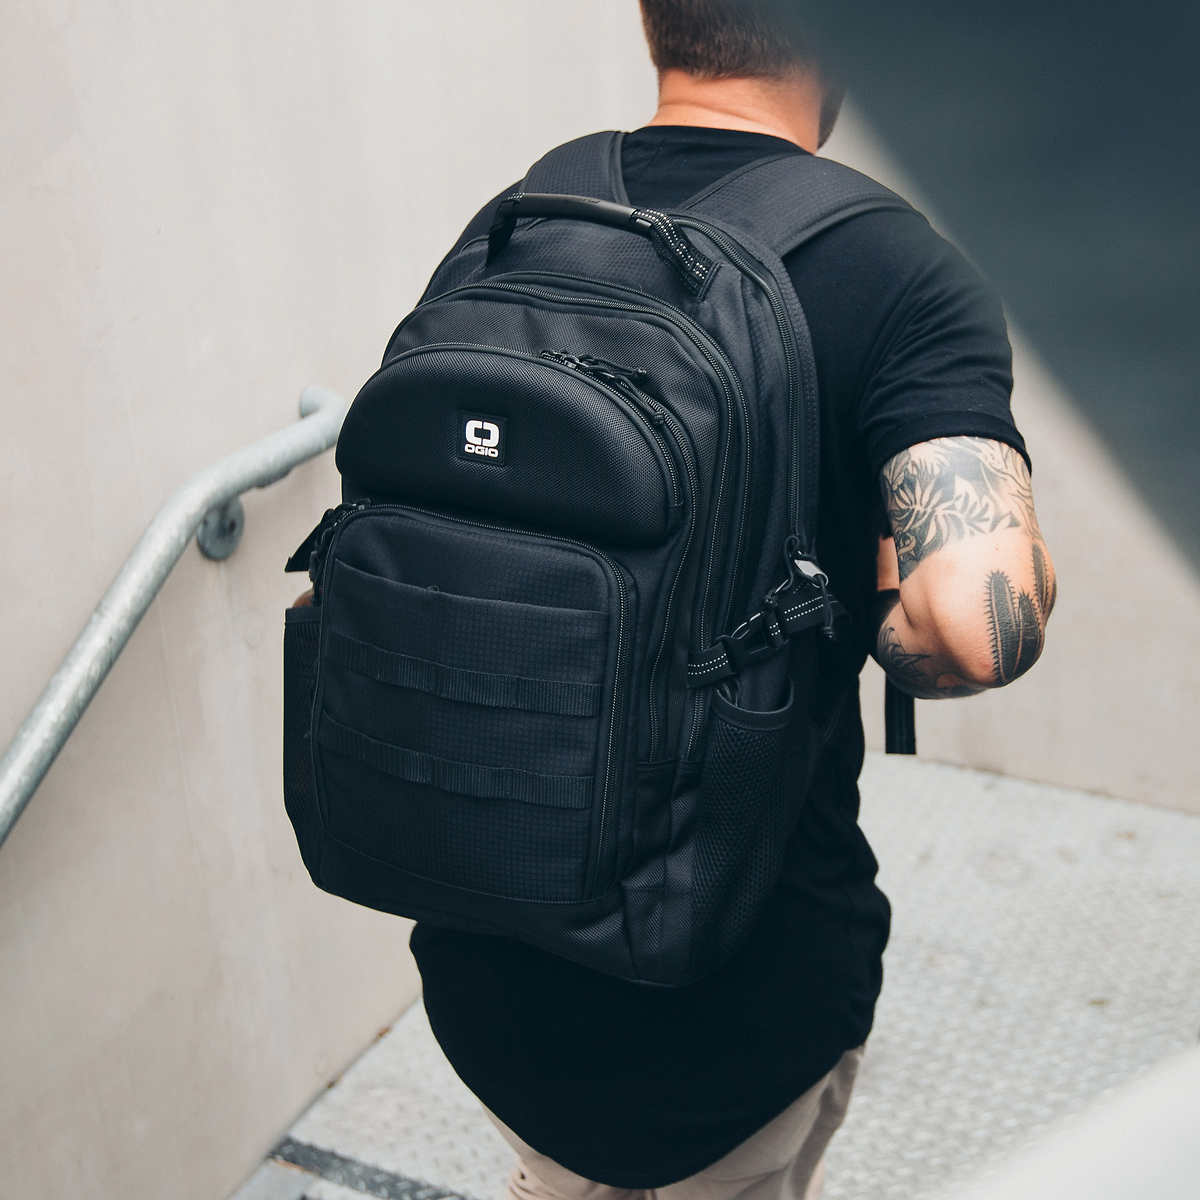

In [25]:
# Select an image for model testing
input = {'url':'https://richmedia.ca-richimage.com/ImageDelivery/imageService?profileId=12026540&id=1390281&recipeId=728'}
response = requests.get(input['url'])
img = Image.open(BytesIO(response.content))
img

In [26]:
# Submit the image to the endpoint and receive the inference
response = client.invoke_endpoint(
    EndpointName='pytorch-inference-2020-03-28-19-22-01-460',
    Body=json.dumps(input),
    ContentType='application/json'
    )
print(str(response['Body'].read(),'utf-8'))

"Prediction: back_pack"
